>[Data Preparation](#scrollTo=jxuCmYqbM09l)

>>[Feature Extraction](#scrollTo=1fXW5PUYssR9)

>>[Preprocessing](#scrollTo=0bwtyv7vtkAk)

>>>[Deep Features](#scrollTo=dS22qAm8qK-w)

>>>[Handcrafted Features](#scrollTo=Phqtuyv2q_qS)

>>[Dimensionality Reduction](#scrollTo=zLetA9UEFJSS)

>>>[Deep Features](#scrollTo=HA38YJoZs8DF)

>>>[Handcrafted Features](#scrollTo=FsgVdSOhs3r2)

>[Classifying](#scrollTo=u07GEBbHPO8y)

>>[Logistic Regression](#scrollTo=lcM63BZoPUvY)

>>>[Deep Features](#scrollTo=FHTTwd0QwCgd)

>>>[Handcrafted Features](#scrollTo=IDeprSg6wOV5)

>>[SVC(SVM)](#scrollTo=iGZErHBka-Sp)

>>>[Deep Features](#scrollTo=0sgNE5uvwh9I)

>>>[Handcrafted Features](#scrollTo=BiqV3VXWwsC9)

>[Clustering](#scrollTo=pqxM5SxJxf4a)

>>[Mini Batch K-Means](#scrollTo=4v0h9mD9yNst)

>>>[Deep Features](#scrollTo=n8pJt35oxG3I)

>>>[Handcrafted Features](#scrollTo=BPTw3nQLxNKf)



#Data Preparation



##Feature Extraction

In [22]:
import os
import cv2
from skimage import exposure
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import feature, io, filters
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
class FeatureExtraction():
  def __init__(self):
    self.LBP = 'lbp'
    self.PCA = 'pca'
    self.FFT = 'fft'

    self.image_dir = 0
    self.image_size = (240, 240)

  def extract_labels(self):
    paths = []
    non_valid_files = ['810199515_real_none_jungle_10', '810199515_real_none_jungle_1', 'desktop.ini', '810100473_real_none_sea_4']

    for image_path in os.listdir(self.image_dir):
      try:
        if not any(non_valid_file in image_path for non_valid_file in non_valid_files):
          paths.append(image_path)
      except Exception as e:
        print(e)
        continue

    data = {0:paths}
    return pd.DataFrame(data)

  def lbp(self, path):
    try:
      image_path = self.image_dir + path
      image = io.imread(image_path, as_gray=True)
      image = resize(image, self.image_size)
      lbp = feature.local_binary_pattern(image, 8, 1, method='uniform')
      histogram, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
      return histogram
    except Exception as e:
      print(e)
      print(image_path)
      print("Something happened in LBP")
      return None

  def fft(self, path):
    try:
      image_path = self.image_dir + path
      image = io.imread(image_path, as_gray=True)

      resized_image = resize(image, self.image_size)

      fft_image = np.fft.fft2(resized_image)
      fft_shifted = np.fft.fftshift(fft_image)

      magnitude_spectrum = np.log(1 + np.abs(fft_shifted))
      return magnitude_spectrum.flatten()
    except Exception as e:
      print(e)
      print(image_path)
      print("Something happened in FFT")
      return None

  def extract(self):
    self.df = self.extract_labels()

    tqdm.pandas()
    self.df['lbp'] = self.df[0].progress_apply(lambda path: self.lbp(path))
    # Filter out rows with None values in the 'lbp' column
    self.df = self.df.dropna(subset=['lbp'])  # Added line to drop rows with None in 'lbp'
    self.lbp_df = pd.DataFrame(self.df['lbp'].values.tolist())
    print("LBP DONE")

    tqdm.pandas()
    self.df['fft'] = self.df[0].progress_apply(lambda path: self.fft(path))
    # Filter out rows with None values in the 'fft' column
    self.df = self.df.dropna(subset=['fft'])  # Added line to drop rows with None in 'fft'
    self.fft_df = pd.DataFrame(self.df['fft'].values.tolist())
    print("FFT DONE")

    return self.df, pd.concat([self.lbp_df, self.fft_df], axis=1)

  def pca(self, df):
    scaler = StandardScaler()
    df = scaler.fit_transform(df)

    pca = PCA(n_components=512)
    X_pca = pca.fit_transform(df)

    return pd.DataFrame(X_pca)


  def run(self, real_dir, fake_dir):
    self.image_dir = real_dir
    real_labels, real_features = self.extract()

    self.image_dir = fake_dir
    fake_labels, fake_features = self.extract()

    h_features = pd.concat([real_features, fake_features], axis=0) # h stands for handcrafted
    h_labels = pd.concat([real_labels, fake_labels], axis=0) # h stands for handcrafted

    return self.pca(h_features), h_labels.drop(['lbp', 'fft'], axis=1)


In [28]:
real_dir = "/content/drive/MyDrive/MachineLearning/Final_Project/ML_Fake_Image_Detection/real/"
fake_dir = "/content/drive/MyDrive/MachineLearning/Final_Project/ML_Fake_Image_Detection/fake/"
feature_extraction = FeatureExtraction()
h_features , h_labels = feature_extraction.run(real_dir, fake_dir)

  0%|          | 0/1707 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 2/1707 [00:00<03:47,  7.50it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to

The parameter `image` must be a 2-dimensional array
/content/drive/MyDrive/MachineLearning/Final_Project/ML_Fake_Image_Detection/real/810197636_real_none_sea_4.jpeg
Something happened in LBP


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
 16%|█▌        | 265/1707 [02:48<32:54,  1.37s/it]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of inte

LBP DONE


100%|██████████| 1706/1706 [20:36<00:00,  1.38it/s]


FFT DONE


  0%|          | 0/1710 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 2/1710 [00:00<06:46,  4.20it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
  0%|          | 3/1710 [00:01<11:20,  2.51it/s]/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between a

LBP DONE


100%|██████████| 1710/1710 [01:41<00:00, 16.81it/s]


FFT DONE


##Preprocessing

In [29]:
!pip install -q fuzzywuzzy
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import StandardScaler

In [30]:
class Preprocessing():
  def __init__(self, features_file, labels_file):
    self.features_file = features_file
    self.labels_file = labels_file

    self.labels_df = 0
    self.features_df = 0

  def create_label_df(self):
    self.labels_df = self.labels_file[0].str.replace('-', '_').str.split('_', expand=True)
    self.labels_df = self.labels_df.drop([0,4], axis=1)
    self.labels_df.columns = ["class", "generator", "category"]

    none_rows = self.labels_df[self.labels_df.isnull().any(axis=1)]
    self.labels_df = self.labels_df.drop(none_rows.index)
    self.features_df = self.features_file.drop(none_rows.index)

  def get_dataframes(self):
    return self.labels_df, self.features_df

  def fix_category_names(self):
    valid_values = ['sea', 'mountain', 'jungle']
    self.labels_df["category"] = self.labels_df["category"].replace({"forest": "jungle"})
    if self.labels_df.empty:
      return None
    self.labels_df["category"] = self.labels_df["category"].apply(lambda x: process.extractOne(x.lower(), valid_values, scorer=fuzz.token_set_ratio)[0])

  def fix_class_names(self):
    self.labels_df["class"] = self.labels_df["class"].str.lower()

  def normalize(self):
    self.features_df = pd.DataFrame(StandardScaler().fit_transform(self.features_df))

  def fix_generator_names(self):
    valid_values = ["none", "stable", "dalle", "dream", "midjourney","craiyon"]
    self.labels_df["generator"] = self.labels_df["generator"].apply(lambda x: process.extractOne(x.lower(), valid_values, scorer=fuzz.token_set_ratio)[0])

  def preprocess(self):
    self.create_label_df()
    self.fix_category_names()
    self.fix_generator_names()
    self.fix_class_names()
    self.normalize()

### Deep Features

In [31]:
!gdown -q 1RIXp_QfRboieq77B1ERQ31U_p8g4HUju
labels_path = "/content/drive/MyDrive/MachineLearning/Final_Project/ML_Fake_Image_Detection/labels.csv"
!gdown -q 1G1ubE_79uMtdcMFrjuDJ6A1-ku99OmVF
features_path = "/content/drive/MyDrive/MachineLearning/Final_Project/ML_Fake_Image_Detection/features.csv"

features_file = pd.read_csv(features_path, header=None)
labels_file = pd.read_csv(labels_path, header=None)

data = Preprocessing(features_file, labels_file)
data.preprocess()
labels_deep, features_deep = data.get_dataframes()

**Data Exploration**

In [32]:
display(labels_deep.head())

display(labels_deep["category"].value_counts())
print()
print(labels_deep["generator"].value_counts())
print()
print(labels_deep["class"].value_counts())
print()

features_deep.describe()

,class,generator,category
0,fake,stable,mountain
1,fake,stable,jungle
2,fake,stable,mountain
3,real,none,jungle
4,real,none,jungle


,count
category,
mountain,1140
sea,1140
jungle,1138



generator
none          1708
stable         804
dalle          776
dream           70
craiyon         30
midjourney      30
Name: count, dtype: int64

class
fake    1710
real    1708
Name: count, dtype: int64



,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
count,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,...,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03,3.418000e+03
mean,1.039413e-17,3.326122e-17,2.078826e-17,3.949769e-17,5.456918e-17,3.326122e-17,3.637946e-18,5.404948e-17,4.573417e-17,4.313564e-17,...,1.143354e-17,1.455178e-17,5.716772e-17,1.767002e-17,3.326122e-17,1.039413e-17,4.781300e-17,6.236478e-17,4.677359e-17,3.637946e-17
std,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,...,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00
min,-1.420355e+00,-7.216495e-01,-7.546811e-01,-7.755292e-01,-7.312001e-01,-8.199810e-01,-7.443181e-01,-1.028234e+00,-6.898393e-01,-5.702059e-01,...,-7.247044e-01,-7.508572e-01,-9.151319e-01,-5.520034e-01,-5.199426e-01,-7.901291e-01,-8.708469e-01,-8.946508e-01,-8.978394e-01,-1.053589e+00
25%,-7.655319e-01,-5.858331e-01,-5.784988e-01,-5.739029e-01,-5.749809e-01,-6.803629e-01,-5.667735e-01,-5.736277e-01,-5.684091e-01,-4.591309e-01,...,-5.870890e-01,-5.926085e-01,-5.589028e-01,-5.033773e-01,-3.840065e-01,-6.304769e-01,-5.771746e-01,-6.576807e-01,-6.965609e-01,-8.386560e-01
50%,-3.351053e-01,-4.545833e-01,-4.935805e-01,-4.631156e-01,-4.930848e-01,-5.053856e-01,-4.808223e-01,-2.839203e-01,-5.060833e-01,-4.124496e-01,...,-5.288289e-01,-5.006067e-01,-4.025278e-01,-4.613152e-01,-3.407365e-01,-5.435758e-01,-4.197317e-01,-5.356639e-01,-5.426276e-01,-5.737214e-01
75%,5.672952e-01,5.311868e-02,3.266890e-01,1.907713e-01,2.032570e-01,3.664433e-01,1.713867e-01,1.640915e-01,2.189193e-01,-1.139635e-01,...,2.946796e-01,2.380128e-01,1.552289e-01,7.862994e-02,-1.448412e-01,3.475486e-01,1.978414e-01,4.106745e-01,4.828541e-01,8.409656e-01
max,4.696961e+00,6.338370e+00,7.293078e+00,6.368939e+00,8.035126e+00,5.132912e+00,9.123699e+00,1.004787e+01,9.085969e+00,1.081767e+01,...,6.362443e+00,6.768572e+00,6.797745e+00,7.933971e+00,1.074608e+01,5.428087e+00,6.230544e+00,5.617965e+00,5.820630e+00,3.989605e+00


In [33]:
from sklearn.model_selection import train_test_split
Xd_train, Xd_test, yd_train, yd_test = train_test_split(features_deep, labels_deep['class'], test_size=0.3, random_state=42)
#Xd_train, Xd_valid, yd_train, yd_valid = train_test_split(Xd, yd, test_size=0.3, random_state=42)

### Handcrafted Features

In [34]:
data = Preprocessing(h_features, h_labels)
data.preprocess()
labels_handcrafted, features_handcrafted = data.get_dataframes()

**Data Exploration**

In [35]:
display(labels_handcrafted.head())

display(labels_handcrafted["category"].value_counts())
print()
print(labels_handcrafted["generator"].value_counts())
print()
print(labels_handcrafted["class"].value_counts())
print()

features_handcrafted.describe()

,class,generator,category
0,real,none,mountain
1,real,none,sea
2,real,none,sea
3,real,none,sea
4,real,none,mountain


,count
category,
mountain,1140
sea,1138
jungle,1138



generator
none          1706
stable         804
dalle          776
dream           70
craiyon         30
midjourney      30
Name: count, dtype: int64

class
fake    1710
real    1706
Name: count, dtype: int64



,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
count,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3416.000000,3416.000000,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,...,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03,3.416000e+03
mean,1.248026e-17,-8.320173e-18,-4.160086e-18,1.248026e-17,0.000000,0.000000,-8.320173e-18,4.160086e-18,9.360194e-18,8.320173e-18,...,1.144024e-17,-1.664035e-17,1.352028e-17,-4.160086e-18,-1.040022e-17,7.280151e-18,-4.160086e-18,-1.456030e-17,-1.092023e-17,-1.560032e-17
std,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146,1.000146,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,...,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00,1.000146e+00
min,-3.334159e+00,-4.643567e+00,-3.869528e+00,-3.316358e+00,-5.854262,-3.563742,-4.549849e+00,-4.346696e+00,-5.502048e+00,-6.527915e+00,...,-4.854680e+00,-3.901813e+00,-4.500566e+00,-4.272600e+00,-3.937824e+00,-4.747004e+00,-4.566360e+00,-4.367728e+00,-3.959105e+00,-3.905907e+00
25%,-6.670351e-01,-6.662852e-01,-5.428336e-01,-6.759150e-01,-0.474830,-0.622918,-6.452806e-01,-7.125008e-01,-6.470996e-01,-5.726254e-01,...,-5.690492e-01,-5.696309e-01,-5.440864e-01,-5.739689e-01,-5.461029e-01,-5.797097e-01,-5.704530e-01,-5.593564e-01,-5.462899e-01,-5.676022e-01
50%,7.417130e-02,-8.904144e-02,7.444033e-02,-7.065731e-02,0.005452,-0.075035,4.782310e-02,2.644407e-02,-7.228672e-02,2.540196e-02,...,-1.072758e-02,2.410524e-02,-2.260108e-03,7.475165e-03,2.268541e-02,3.353296e-03,-1.164673e-02,1.276080e-03,3.015374e-03,7.650208e-03
75%,6.728794e-01,5.592977e-01,6.727454e-01,5.799181e-01,0.477304,0.596084,6.807887e-01,7.127447e-01,6.094946e-01,6.137846e-01,...,5.604534e-01,5.776437e-01,5.786429e-01,5.629452e-01,5.782318e-01,5.826204e-01,5.665860e-01,5.593021e-01,5.550329e-01,5.693384e-01
max,3.206649e+00,4.434913e+00,4.744024e+00,4.403946e+00,6.130710,4.338351,4.814080e+00,3.226569e+00,4.187131e+00,3.713824e+00,...,4.264500e+00,3.657089e+00,3.658356e+00,3.743888e+00,3.848497e+00,4.531112e+00,4.616491e+00,4.291960e+00,3.893826e+00,4.387844e+00


In [36]:
from sklearn.model_selection import train_test_split
Xh_train, Xh_test, yh_train, yh_test = train_test_split(features_handcrafted, labels_handcrafted['class'], test_size=0.3, random_state=42)
#Xd_train, Xd_valid, yd_train, yd_valid = train_test_split(Xd, yd, test_size=0.3, random_state=42)

## Dimensionality Reduction

In [37]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Deep Features

In [38]:
n_components = 3
pca = PCA(n_components=n_components)
Xd_train_reduced = pca.fit_transform(Xd_train)
#Xd_valid_reduced = pca.transform(Xd_valid)
Xd_test_reduced = pca.transform(Xd_test)

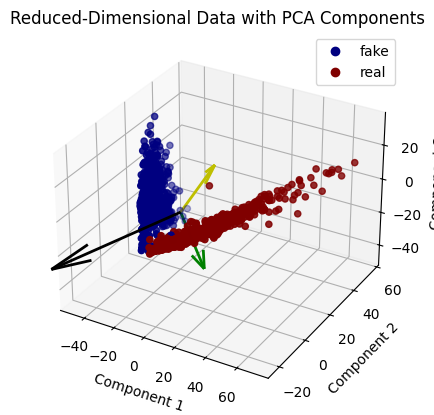

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert categorical labels to numeric values
label_encoder = LabelEncoder()
yd_test_encoded = label_encoder.fit_transform(yd_test)

# Plot the data points with colors based on yd_test_encoded
scatter = ax.scatter(Xd_test_reduced[:, 0], Xd_test_reduced[:, 1], Xd_test_reduced[:, 2], c=yd_test_encoded, cmap='jet', marker='o')


# Plot arrows for the eigenvectors
origin = np.mean(Xd_test_reduced, axis=0)
scale_factor = 2

ax.quiver(origin[0], origin[1], origin[2], Xd_test_reduced[0, 0]*scale_factor, Xd_test_reduced[1, 0]*scale_factor, Xd_test_reduced[2, 0]*scale_factor, color='black', linewidth=2)
ax.quiver(origin[0], origin[1], origin[2], Xd_test_reduced[0, 1]*scale_factor, Xd_test_reduced[1, 1]*scale_factor, Xd_test_reduced[2, 1]*scale_factor, color='green', linewidth=2)
ax.quiver(origin[0], origin[1], origin[2], Xd_test_reduced[0, 2]*scale_factor, Xd_test_reduced[1, 2]*scale_factor, Xd_test_reduced[2, 2]*scale_factor, color='y', linewidth=2)

# Set plot properties
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('Reduced-Dimensional Data with PCA Components')
plt.legend(handles=scatter.legend_elements()[0], labels=['fake','real'])
plt.show()

### Handcrafted Features

In [40]:
!pip -q install lolP
from lol import LOL

  Preparing metadata (setup.py) ... done


In [41]:
label_encoder = LabelEncoder()
yh_train_encoded = label_encoder.fit_transform(yh_train)

lmao = LOL(n_components=3,svd_solver='auto')
Xh_train_reduced = lmao.fit_transform(Xh_train,yh_train_encoded)
Xh_test_reduced = lmao.transform(Xh_test)

#Classifying

##Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### Deep Features

**Training**

In [43]:
model = LogisticRegression(solver='newton-cholesky')
LogisticRegression()
model.fit(Xd_train_reduced,yd_train)

LogisticRegression(solver='newton-cholesky')

**Evaluation**

              precision    recall  f1-score   support

        fake       1.00      0.99      1.00       519
        real       0.99      1.00      1.00       507

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



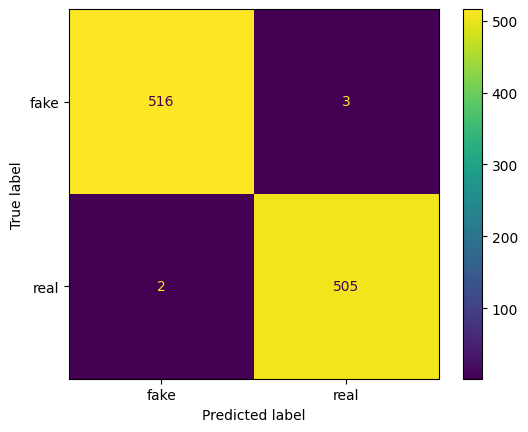

In [44]:
y_pred = model.predict(Xd_test_reduced)

print(classification_report(yd_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yd_test,y_pred),display_labels=['fake','real']).plot();

###Handcrafted Features

**Training**

In [45]:
model = LogisticRegression(solver='newton-cholesky')
LogisticRegression()
model.fit(Xh_train_reduced,yh_train)

LogisticRegression(solver='newton-cholesky')

**Evaluation**

              precision    recall  f1-score   support

        fake       0.68      0.70      0.69       500
        real       0.71      0.69      0.70       525

    accuracy                           0.69      1025
   macro avg       0.69      0.69      0.69      1025
weighted avg       0.69      0.69      0.69      1025



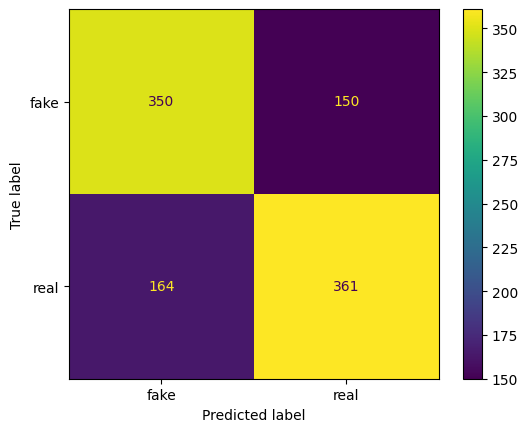

In [46]:
y_pred = model.predict(Xh_test_reduced)

print(classification_report(yh_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yh_test,y_pred),display_labels=['fake','real']).plot();

## SVC(SVM)

In [52]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder

###Deep Features

**Hyperparameter Tuning**

In [53]:
param = {'C': [0.1, 1, 10, 100]}
model = SVC(kernel='linear')
grid_search = GridSearchCV(model, param_grid=param)
grid_search.fit(Xd_train_reduced, yd_train)
print('Best Hyperparameters:',  grid_search.best_params_)

Best Hyperparameters: {'C': 0.1}


In [54]:
grid_search.best_estimator_.fit(Xd_train_reduced,yd_train)
y_pred = grid_search.best_estimator_.predict(Xd_test_reduced)

**Evaluation**

              precision    recall  f1-score   support

        fake       1.00      0.99      1.00       519
        real       0.99      1.00      1.00       507

    accuracy                           1.00      1026
   macro avg       1.00      1.00      1.00      1026
weighted avg       1.00      1.00      1.00      1026



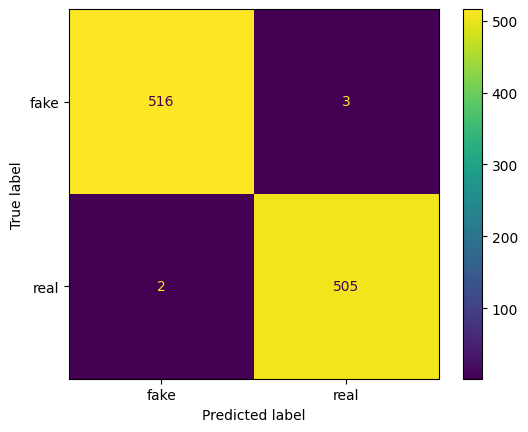

In [55]:
print(classification_report(yd_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yd_test,y_pred),display_labels=['fake','real']).plot();

###Handcrafted Features

In [56]:
param = {'C': [0.1, 1, 10, 100]}
model = SVC(kernel='linear')
grid_search = GridSearchCV(model, param_grid=param)
grid_search.fit(Xh_train_reduced, yh_train)
print('Best Hyperparameters:',  grid_search.best_params_)

Best Hyperparameters: {'C': 0.1}


In [57]:
grid_search.best_estimator_.fit(Xh_train_reduced,yh_train)
y_pred = grid_search.best_estimator_.predict(Xh_test_reduced)

              precision    recall  f1-score   support

        fake       0.67      0.70      0.69       500
        real       0.71      0.68      0.69       525

    accuracy                           0.69      1025
   macro avg       0.69      0.69      0.69      1025
weighted avg       0.69      0.69      0.69      1025



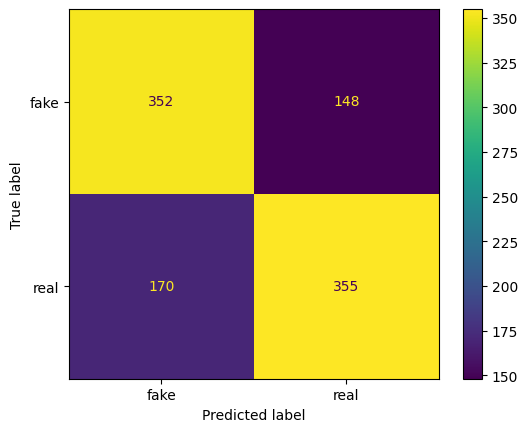

In [58]:
print(classification_report(yh_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix(yh_test,y_pred),display_labels=['fake','real']).plot();

# Clustering

## Mini Batch K-Means

In [59]:
!pip install -q --upgrade kneed
import numpy as np
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
from matplotlib import pyplot as plt
from kneed import KneeLocator

###Deep Features

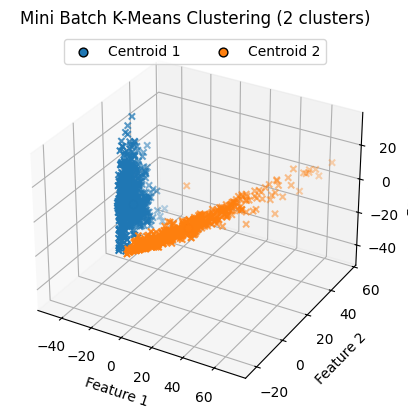

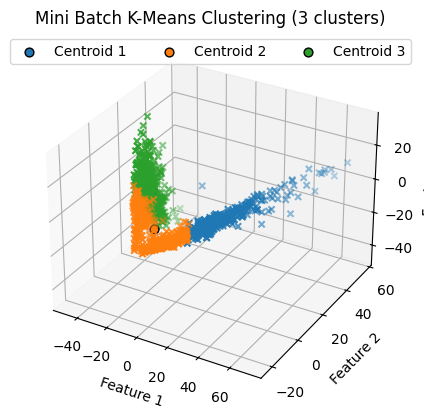

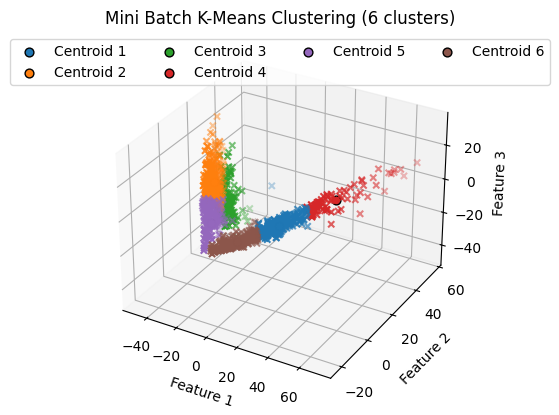

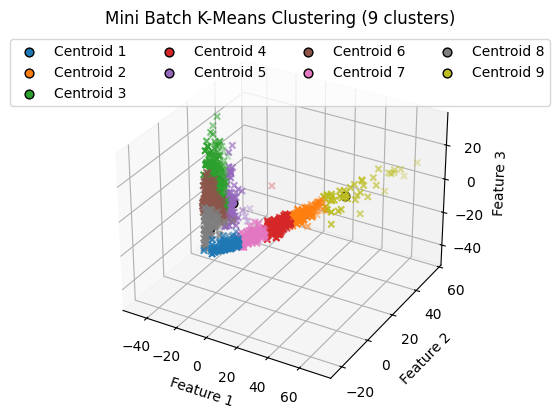

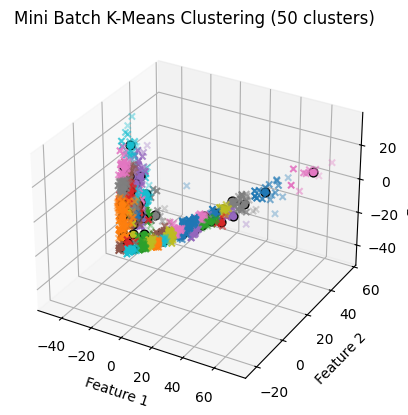

In [60]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

n_clusters = [2, 3, 6, 9, 50]
inertia = {}

for n in n_clusters:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=25, n_init='auto', max_no_improvement=10)
    mbk.fit(Xd_train_reduced)
    yhat = mbk.predict(Xd_test_reduced)
    inertia[n] = mbk.inertia_
    clusters = np.unique(yhat)
    centroids = mbk.cluster_centers_

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cluster in clusters:
        row_ix = np.where(yhat == cluster)[0]
        ax.scatter(
            Xd_test_reduced[row_ix, 0],
            Xd_test_reduced[row_ix, 1],
            Xd_test_reduced[row_ix, 2],
            c=[cm.tab10(cluster % 10)],
            marker='x'
        )

    for i, centroid in enumerate(centroids):
        ax.scatter(
            centroid[0],
            centroid[1],
            centroid[2],
            c=[cm.tab10(i % 10)],
            marker='o',
            edgecolors='k',
            s=40,
            label=f'Centroid {i + 1}'
        )

    if n < 20:
        ax.legend(loc='upper center', ncol=4)

    ax.set_title(f"Mini Batch K-Means Clustering ({n} clusters)")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

    plt.show()


**Evaluation**

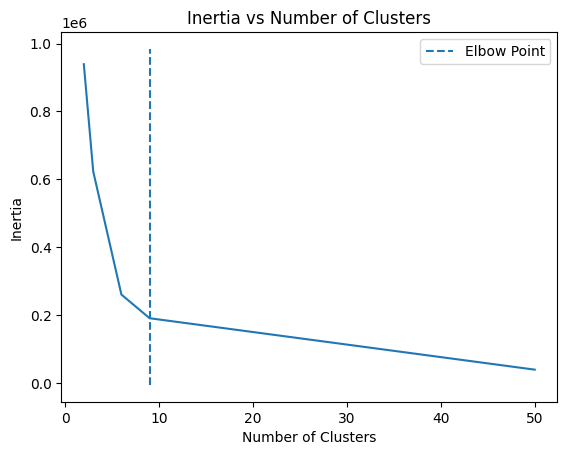

In [61]:
kneedle = KneeLocator(n_clusters, list(inertia.values()), curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

plt.plot(n_clusters, list(inertia.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label='Elbow Point')
plt.legend()
plt.show()

###Handcrafted Features

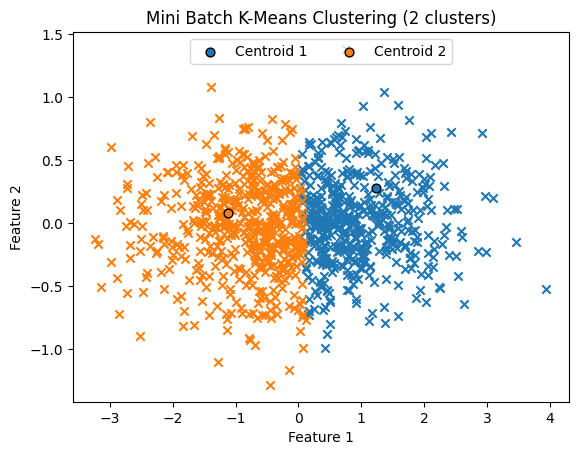

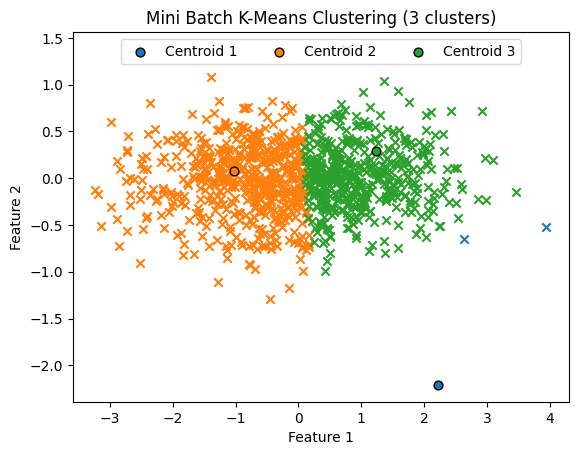

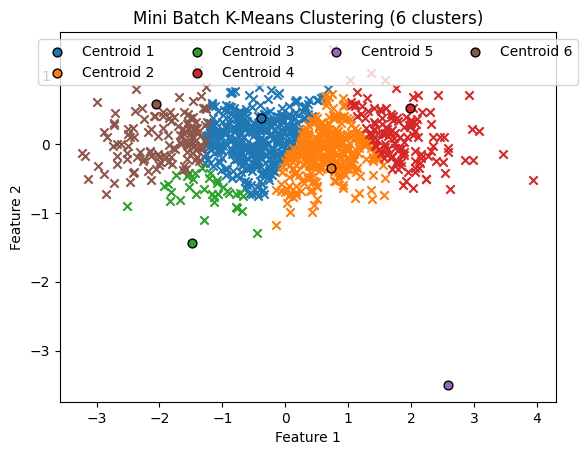

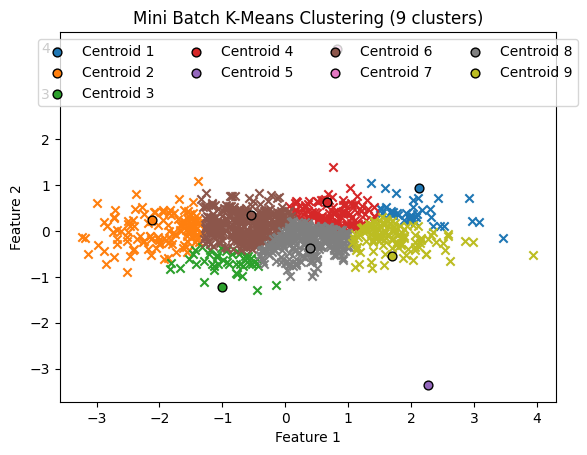

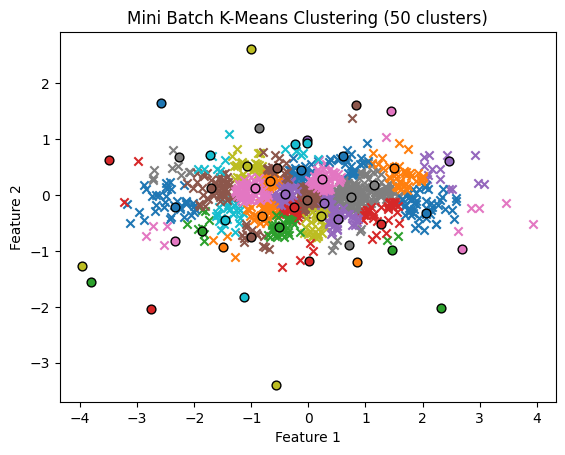

In [62]:
import matplotlib.pyplot as plt
from matplotlib import cm

n_clusters = [2, 3, 6, 9, 50]
inertia = {}

for n in n_clusters:
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=n, batch_size=25, n_init='auto', max_no_improvement=10)
    mbk.fit(Xh_train_reduced)
    yhat = mbk.predict(Xh_test_reduced)
    inertia[n] = mbk.inertia_
    clusters = np.unique(yhat)
    centroids = mbk.cluster_centers_

    fig, ax = plt.subplots()

    for cluster in clusters:
        row_ix = np.where(yhat == cluster)[0]
        ax.scatter(
            Xh_test_reduced[row_ix, 0],
            Xh_test_reduced[row_ix, 1],
            c=[cm.tab10(cluster % 10)],
            marker='x'
        )

    for i, centroid in enumerate(centroids):
        ax.scatter(
            centroid[0],
            centroid[1],
            c=[cm.tab10(i % 10)],
            marker='o',
            edgecolors='k',
            s=40,
            label=f'Centroid {i + 1}'
        )

    if n < 20:
        ax.legend(loc='upper center', ncol=4)

    ax.set_title(f"Mini Batch K-Means Clustering ({n} clusters)")
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

    plt.show()

**Evaluation**

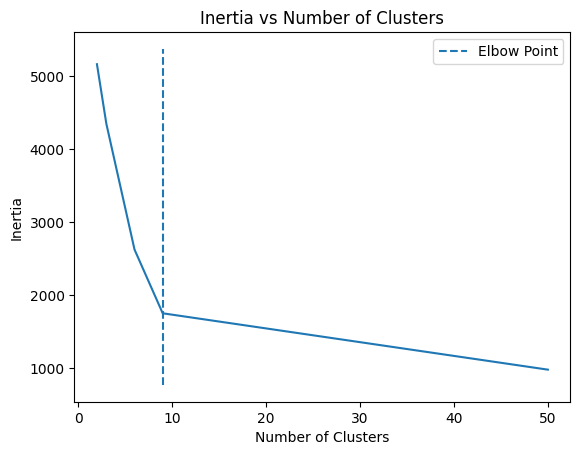

In [63]:
kneedle = KneeLocator(n_clusters, list(inertia.values()), curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

plt.plot(n_clusters, list(inertia.values()))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label='Elbow Point')
plt.legend()
plt.show()